# Introduction 

It is generally known by railway traffic managers (and the public) that bad weather is one major reason for widespread rail traffic disruption. While several different weather situations affects to rail traffic, especially long lasting snow storms are known to be very problematic for the rail traffic. 

This project tries to analyse rail traffic disruptions caused by bad weather. 

Train network is naturally very interconnected system and delay of one train often affects to several others. Here, we anyway consider only effects of weather and leave these dependecies out. This keeps things much more simplier but of course cause some 'noise' to the data.

First some necessary initialisation tasks

In [1]:
install.packages("brms")
install.packages("tidyverse")
install.packages("anytime")


The downloaded binary packages are in
	/var/folders/_y/7131d4pj4xb35rq955c6z6w80000gn/T//Rtmp8Evrax/downloaded_packages


also installing the dependencies ‘highr’, ‘xfun’, ‘rematch’, ‘knitr’, ‘tinytex’, ‘DBI’, ‘curl’, ‘cellranger’, ‘clipr’, ‘fs’, ‘rmarkdown’, ‘whisker’, ‘selectr’, ‘broom’, ‘dbplyr’, ‘forcats’, ‘haven’, ‘hms’, ‘httr’, ‘lubridate’, ‘modelr’, ‘readr’, ‘readxl’, ‘reprex’, ‘rvest’, ‘tidyr’, ‘xml2’




The downloaded binary packages are in
	/var/folders/_y/7131d4pj4xb35rq955c6z6w80000gn/T//Rtmp8Evrax/downloaded_packages


also installing the dependency ‘RApiDatetime’




The downloaded binary packages are in
	/var/folders/_y/7131d4pj4xb35rq955c6z6w80000gn/T//Rtmp8Evrax/downloaded_packages


Loading required package: lubridate

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: Rcpp
Loading 'brms' package (version 2.6.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.


In [3]:
require(lubridate)
library(anytime)
library(ggplot2)
library(brms)
theme_set(theme_minimal())

Loading required package: lubridate

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: Rcpp
Loading 'brms' package (version 2.6.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.


# Description of the data, and the analysis problem

For the task we need train delay information among with weather data. Train delay information is provided by Finnish Transport Agency (FTA). Online data is available at https://digitrafic.com. In our case, we use archive data got directly from FTA. Our dataset has been pre-processed so that train information is reported with one hour interval. The dataset contains trains delays reported on every hour on every station. Delays are reported as *sum* of delays of all trains arrived to the station during the particular hour. The dataset contain additional delays between train stations and cumulated delays from the start station. Here, we use additional delays. 

Finnish Meteorological Institute (FMI) provides weather observations. The data is available online (see https://en.ilmatieteenlaitos.fi/open-data for more details). Our data fetched from the online system and stored separately. The data contains aggregation of weather observations withing 100 kilometers and particular hour from all trains stations and times when trains have arrived to the station.

Our archive contain data from 2010 to 2018. Train delay data and weather data have been concatted to the one single dataframe. The whole dataset contains over 16 million rows which is beyond a scope of this project. Thus we use only subset of the data. For training purposes, we use 10 days of data from 1st January to 10th January 2010. For validation purposes, we use corresponding 10 days period from 2011. Training dataset contains 53 412 rows and validation dataset 52 564 rows.

More detailed description of the parameters are listed below.

```
time:                start time of one hour interval
trainstation:        train station short code
train_type:          K -> inter city
                     L -> commuter
                     T -> cargo
                     M -> other
train_count:         amount of trains passed the station during the particular hour
total_delay:         amount of delay at the end station of the train
delay:               amount of delay between previous and current station
name:                observation station name
lat:                 train station latitude
lon:                 train station longitude
pressure:            air pressure (hPa)
max_temperature:     maximum temperature during the time interval (C)
min_temperature:     minimum temperature (C)
mean_temperature:    mean temperature (C)
mean_dewpoint:       mean dew point (C)
mean_humidity:       mean humidity (percents)
mean_winddirection:  mean wind direction (degrees)
mean_windspeedms:    mean wind speed (m/s), 
max_windgust:        maximum wind gust (m/s)
max_precipitation1h: 1 hour precipitation accumulation (mm)
max_snowdepth:       maximum snow depth (cm)
max_n:               maximum cloudiness (1/8)
min_vis:             minimum visibility (m) 
min_clhb:            minimum cloud base height (m)
max_precipitation3h: 3 hour precipitation accumulation (mm)
max_precipitation6h: 6 hour precipitation accumulation (mm)
flashcount:          flash count with 30 km radius from the train station
```
\- 99 stands for missing value

Data license is CC4BY. 

We load data from csv file following:

In [12]:
data_file <- "data/tiny_filtered.csv"
# data_file <- "data/2010q1_filtered.csv"
val_data_file <- "data/validation.csv"

In [102]:
df <- read.csv(data_file)
df$datetime <- anytime::anytime(df$time)

In [3]:
head(df)
tail(df)
dim(df)

X,time,trainstation,train_type,train_count,total_delay,delay,name,lat,lon,⋯,max_windgust,max_precipitation1h,max_snowdepth,max_n,min_vis,min_clhb,max_precipitation3h,max_precipitation6h,flashcount,datetime
1287675,2010-01-01 00:00:00 UTC,HKH,L,1,0,11,Helsinki-Vantaan lentoasema,60.3267,24.95675,⋯,9,0,41,8,6110,1300,0,0,0,2010-01-01
1283303,2010-01-01 00:00:00 UTC,HKH,K,1,0,0,Helsinki-Vantaan lentoasema,60.3267,24.95675,⋯,9,0,41,8,6110,1300,0,0,0,2010-01-01
1284384,2010-01-01 00:00:00 UTC,HKH,L,2,0,1,Helsinki-Vantaan lentoasema,60.3267,24.95675,⋯,9,0,41,8,6110,1300,0,0,0,2010-01-01
1296206,2010-01-01 00:00:00 UTC,HKI,K,1,1,0,Kaisaniemi,60.1752,24.94459,⋯,9,0,26,8,3440,210,0,0,0,2010-01-01
1296264,2010-01-01 00:00:00 UTC,HKI,L,1,0,16,Kaisaniemi,60.1752,24.94459,⋯,9,0,26,8,3440,210,0,0,0,2010-01-01
1296340,2010-01-01 00:00:00 UTC,HKI,L,3,0,12,Kaisaniemi,60.1752,24.94459,⋯,9,0,26,8,3440,210,0,0,0,2010-01-01


,X,time,trainstation,train_type,train_count,total_delay,delay,name,lat,lon,⋯,max_windgust,max_precipitation1h,max_snowdepth,max_n,min_vis,min_clhb,max_precipitation3h,max_precipitation6h,flashcount,datetime
53407,65131,2010-01-09 23:00:00 UTC,VKS,L,2,0,0,Helsinki-Vantaan lentoasema,60.3267,24.95675,⋯,3,0,42,9,370,50,0,0,0,2010-01-09 23:00:00
53408,22635,2010-01-09 23:00:00 UTC,VMO,K,1,0,0,Kumpula,60.2031,24.96131,⋯,2,0,39,9,300,30,0,0,0,2010-01-09 23:00:00
53409,23969,2010-01-09 23:00:00 UTC,VMO,L,1,0,0,Kumpula,60.2031,24.96131,⋯,2,0,39,9,300,30,0,0,0,2010-01-09 23:00:00
53410,22966,2010-01-09 23:00:00 UTC,VMO,L,1,0,1,Kumpula,60.2031,24.96131,⋯,2,0,39,9,300,30,0,0,0,2010-01-09 23:00:00
53411,1321539,2010-01-09 23:00:00 UTC,VTI,K,2,0,48,Ruukki,64.6842,25.08919,⋯,2,0,27,-99,-99,-99,0,0,0,2010-01-09 23:00:00
53412,63995,2010-01-09 23:00:00 UTC,YLÖ,K,1,1,17,Tampere-Pirkkalan lentoasema,61.4184,23.61811,⋯,1,-99,-99,9,100,30,-99,-99,0,2010-01-09 23:00:00


[1] 53412    28

Timeseries of the delay is plotted below. One can see, that the timeseries is very spiky which is expected. Normally trains goes relatively well on schedule and when bad delays happen, disruptions are typically widespread accross the rail network. One may also wonder high base value of the delays (roughly 100 minutes). It's good to remember that values are *sum* of delays of all trains arrived to all stations. 

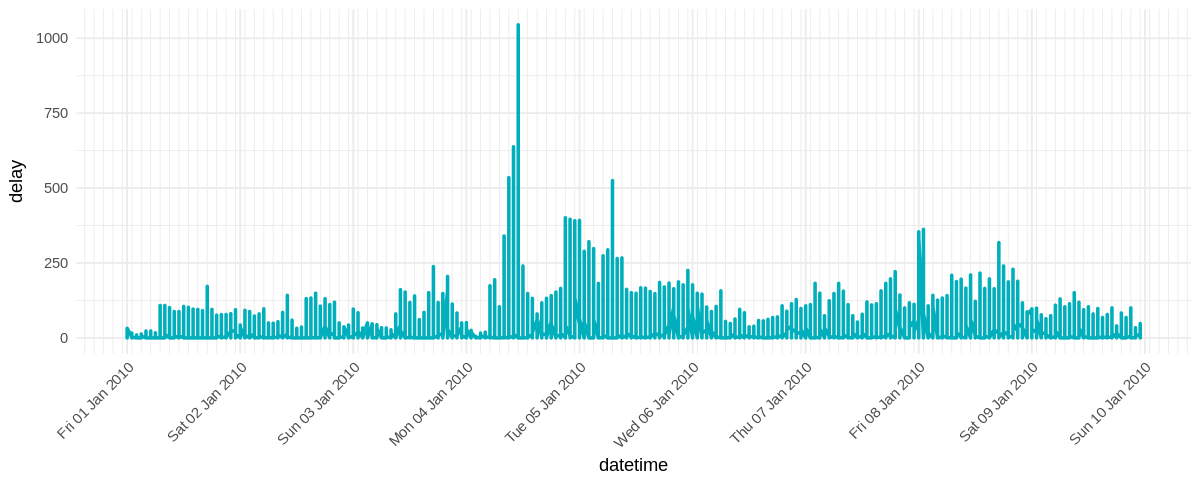

In [4]:
library(scales)
options(repr.plot.width=10, repr.plot.height=4)
ggplot(data = df, aes(x = datetime, y = delay))+
  geom_line(color = "#00AFBB", size = 1) +
  scale_x_datetime(date_labels = "%a %d %b %Y", breaks = date_breaks("1 day"),
  minor_breaks = date_breaks("2 hour")) +
  theme(axis.text.x=element_text(angle=45, hjust=1))

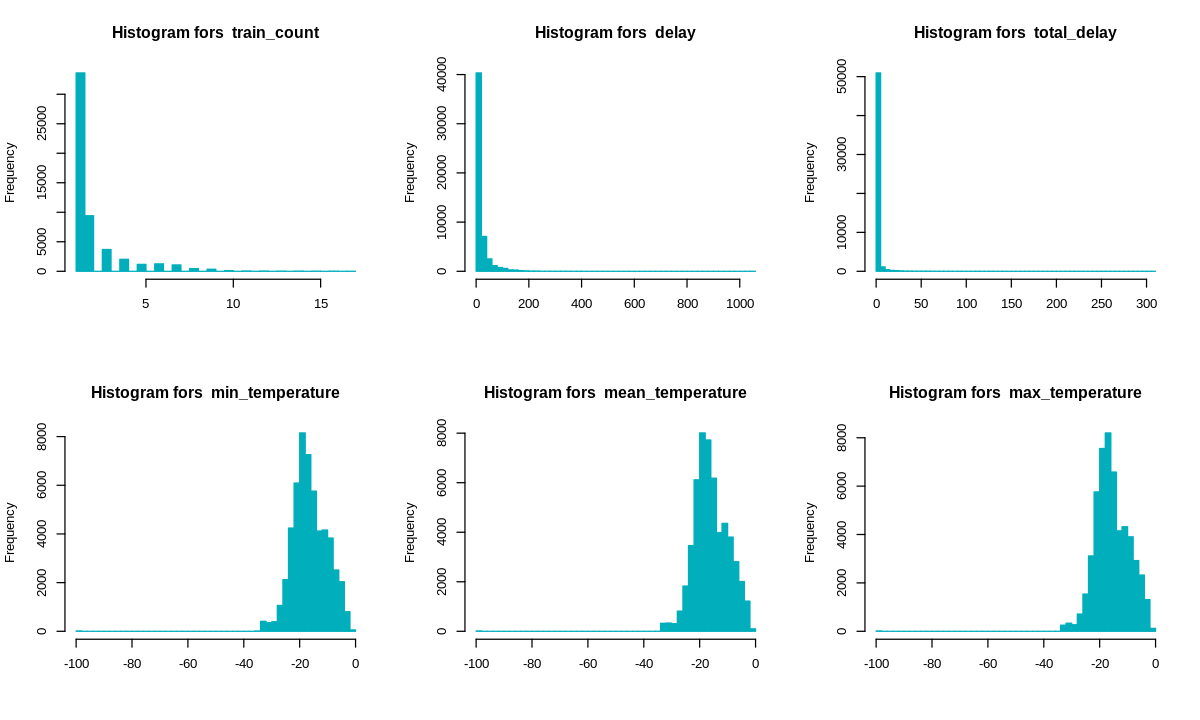

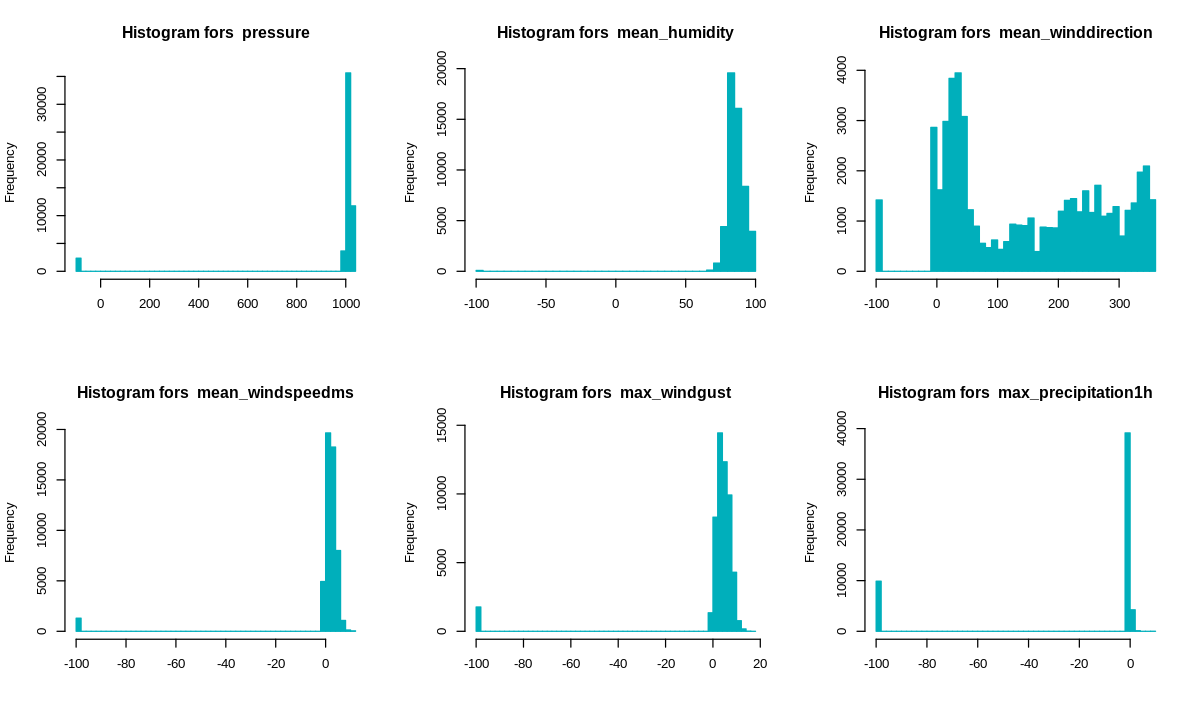

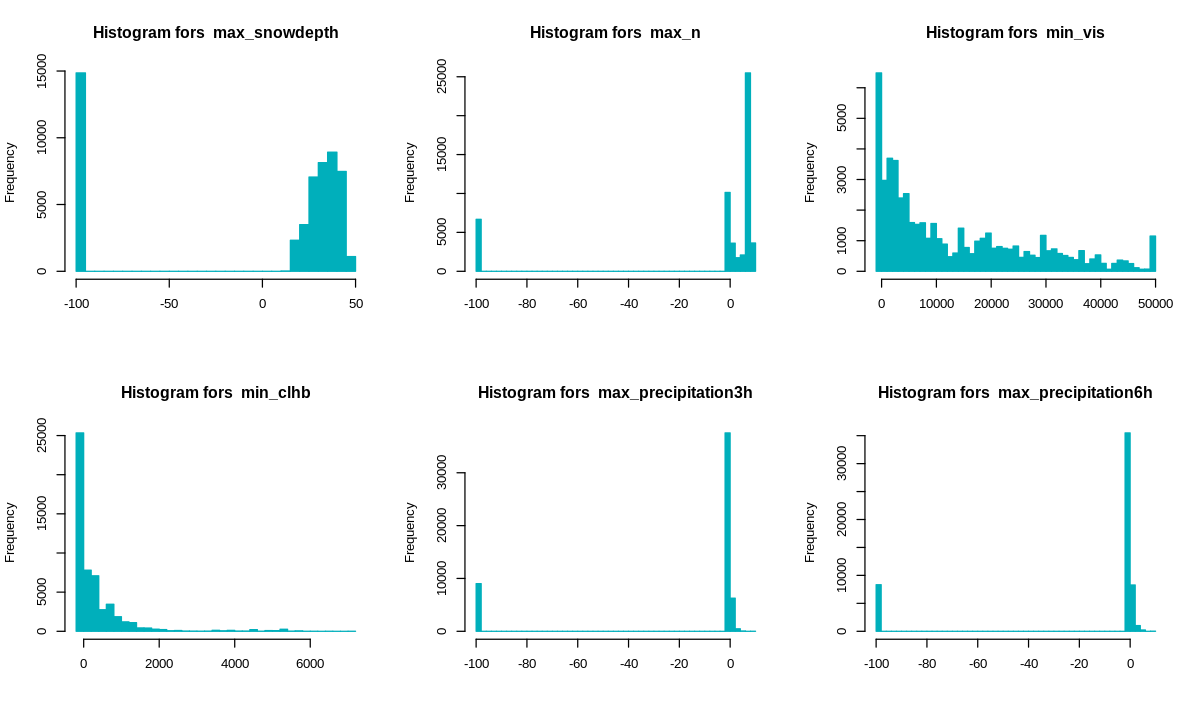

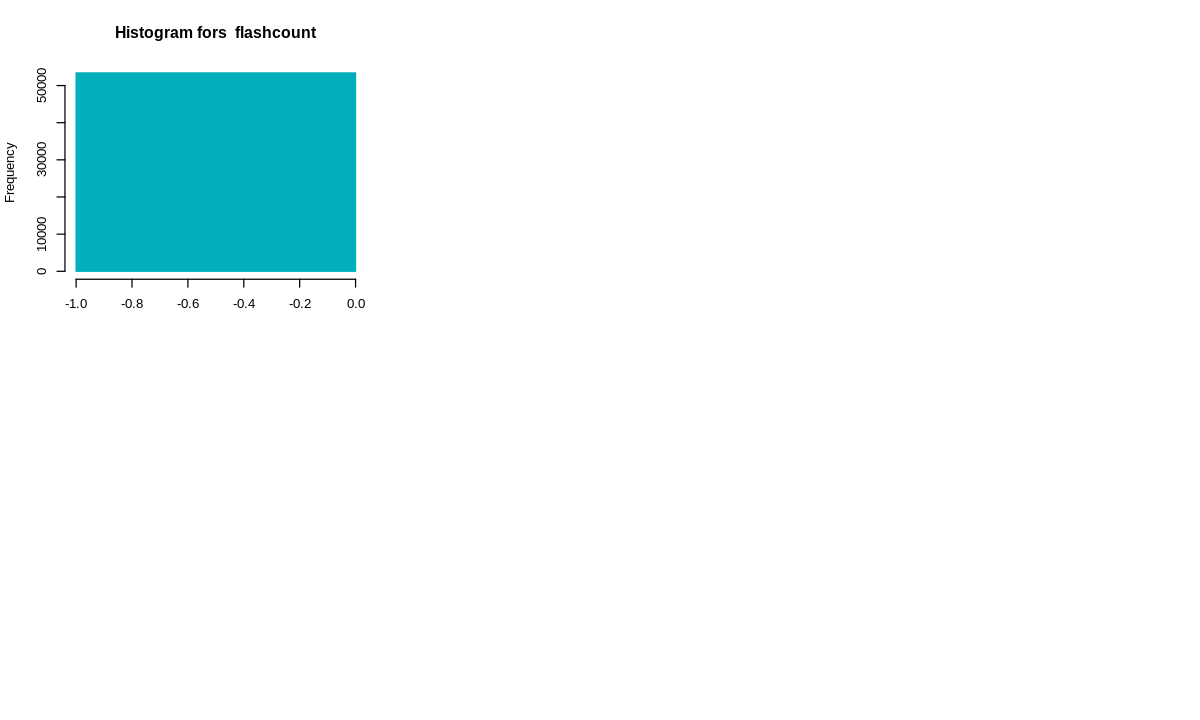

In [5]:
library(reshape2)
cols = c('train_count', 'delay', 'total_delay', 
         'min_temperature', 'mean_temperature', 
         'max_temperature', 'pressure', 'mean_humidity', 
         'mean_winddirection', 'mean_windspeedms', 'max_windgust', 
         'max_precipitation1h', 'max_snowdepth', 'max_n', 
         'min_vis', 'min_clhb', 'max_precipitation3h', 
         'max_precipitation6h', 'flashcount')
#ggplot(melt(df, id=cols), aes(x = value)) + 
#    facet_wrap(~ variable, scales = "free", ncol = 2) + 
#    geom_histogram(binwidth = .5)
par(mfrow=c(2,3))
options(repr.plot.width=10, repr.plot.height=6)
#subset(df, 'max_snowdepth'!=-99)
for (col in cols){
#    ggplot(df, aes(data)) + 
#      facet_wrap(~ col, scales = "free", ncol = 2) + 
#      geom_histogram(stat="count")
    hist(subset(df, col != -99)[,col],
         main=paste("Histogram fors ",col),
         xlab='', col='#00AFBB', border='#00AFBB',
         breaks=50)
}


Histograms for all rows where delay between stations have been over 5 minutes.

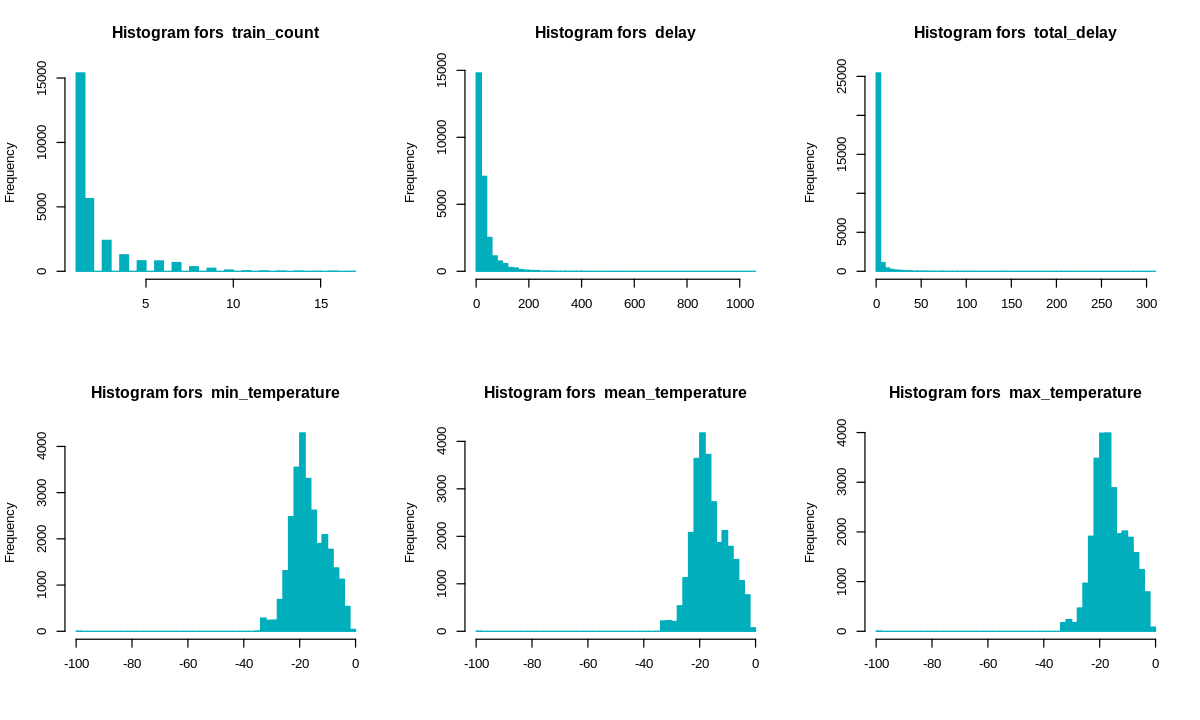

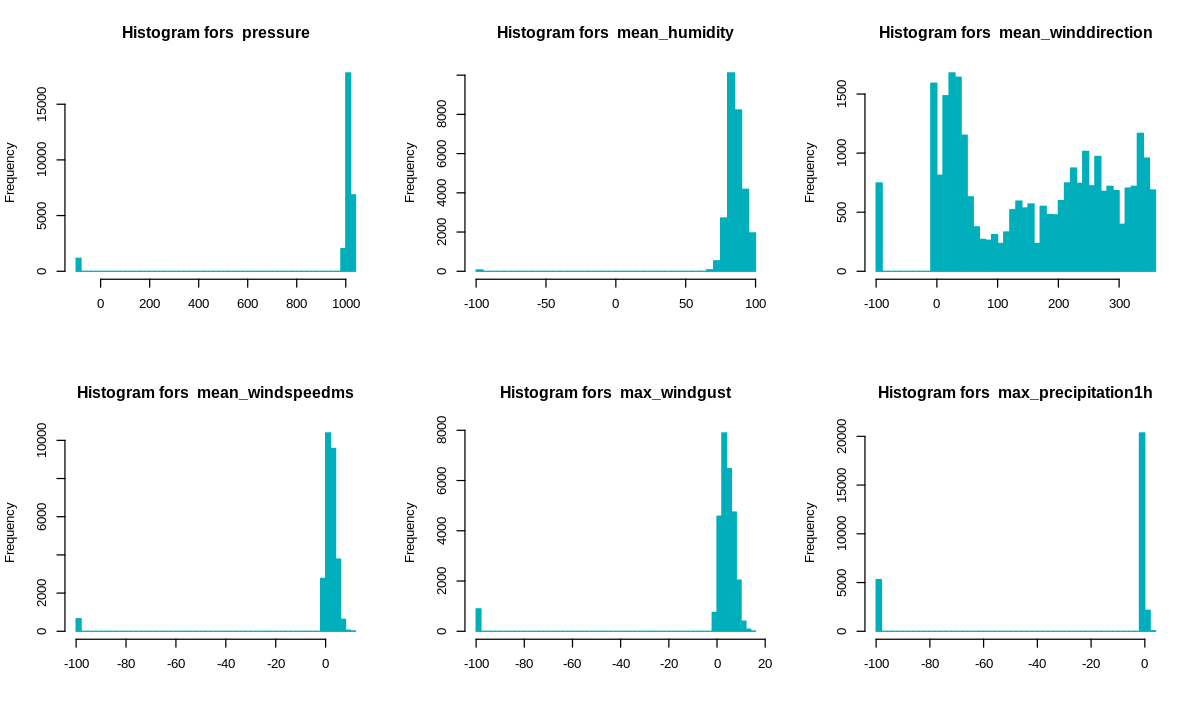

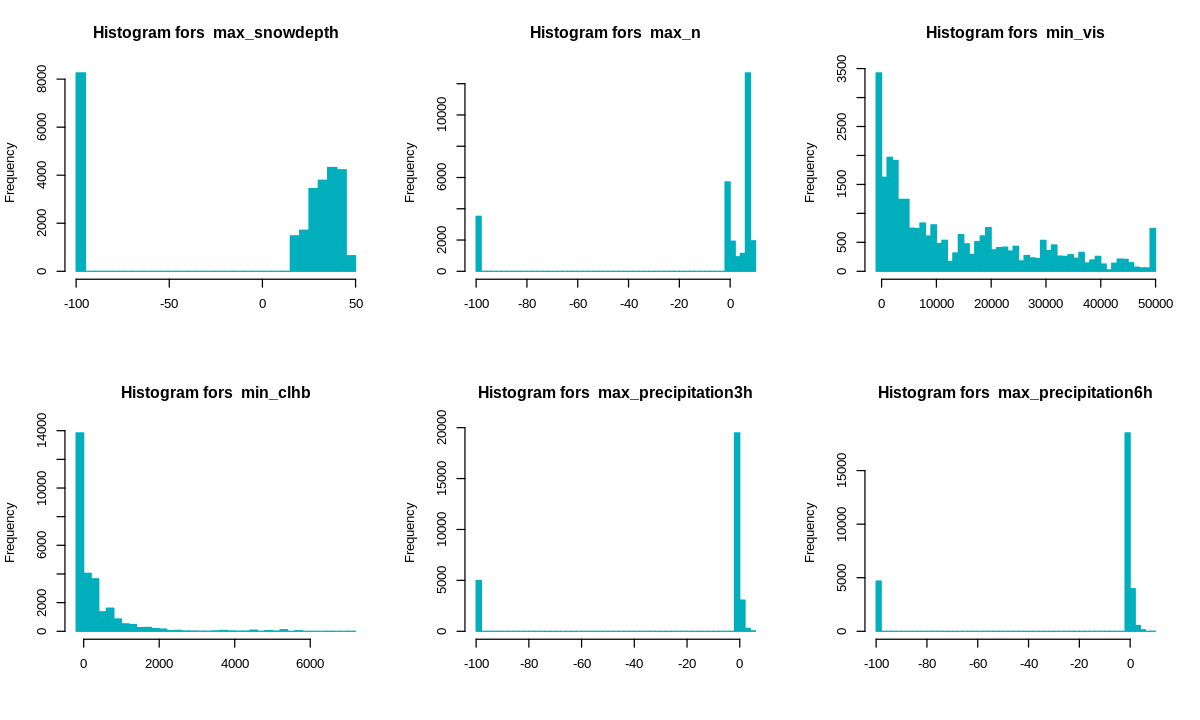

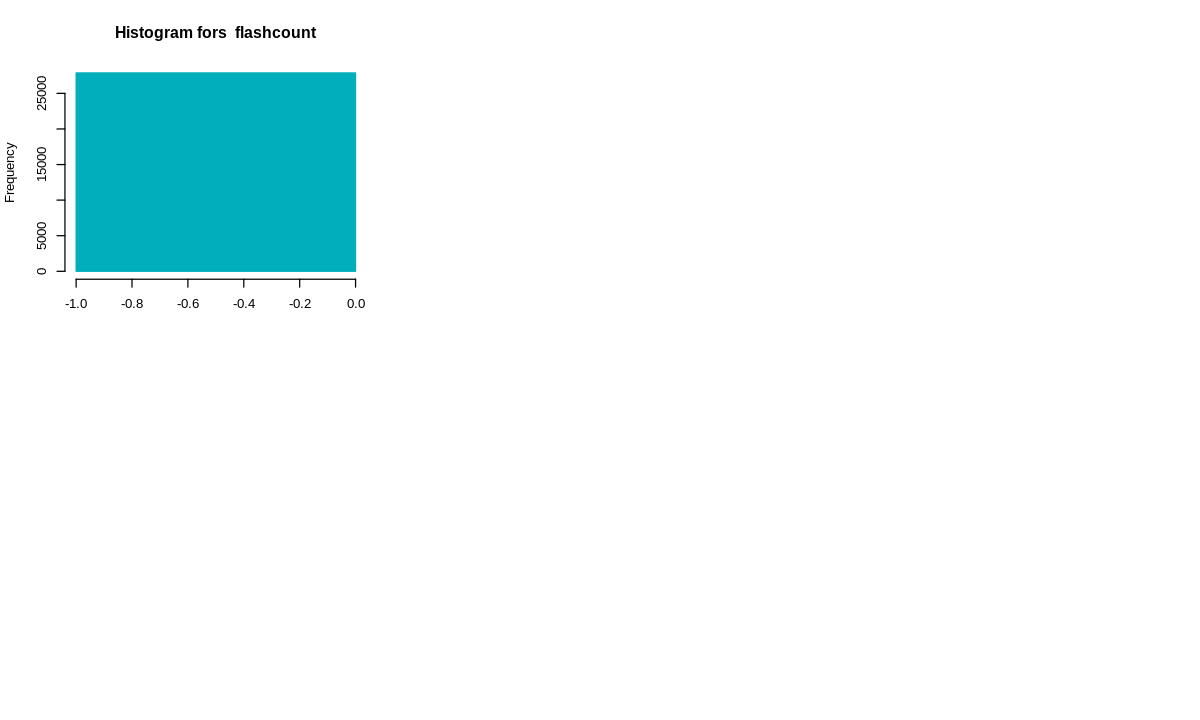

In [6]:
df_delay <- df[df$delay > 5,]
par(mfrow=c(2,3))
for (col in cols){
    hist(subset(df_delay, col != -99)[,col],
         main=paste("Histogram fors ",col),
         xlab='', col='#00AFBB', border='#00AFBB',
         breaks=50)
}

# Description of the model
...

# Description of the prior choices
...

# Stan
...

In [125]:
options(mc.cores = parallel::detectCores())
fit1 <- brm(
    cbind(delay) ~ (1|p|min_temperature) + (1|q|pressure) + 
                   (1|r|mean_humidity) + (1|s|max_windgust) + 
                   (1|t|min_clhb) + (1|u|max_precipitation6h),
    data = df
)

Compiling the C++ model
Start sampling


# Convergence diagnostics
...

In [126]:
summary(fit1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: cbind(delay) ~ (1 | p | min_temperature) + (1 | q | pressure) + (1 | r | mean_humidity) + (1 | s | max_windgust) + (1 | t | min_clhb) + (1 | u | max_precipitation6h) 
   Data: df (Number of observations: 53412) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~max_precipitation6h (Number of levels: 57) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)    10.66      1.32     8.50    13.65       1374 1.00

~max_windgust (Number of levels: 19) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     2.00      0.56     1.22     3.37       1244 1.00

~mean_humidity (Number of levels: 37) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     5.40      0.95     3.79     7.50       1229 1.00

~min_clhb (Number of levels: 268) 
              Estimate E

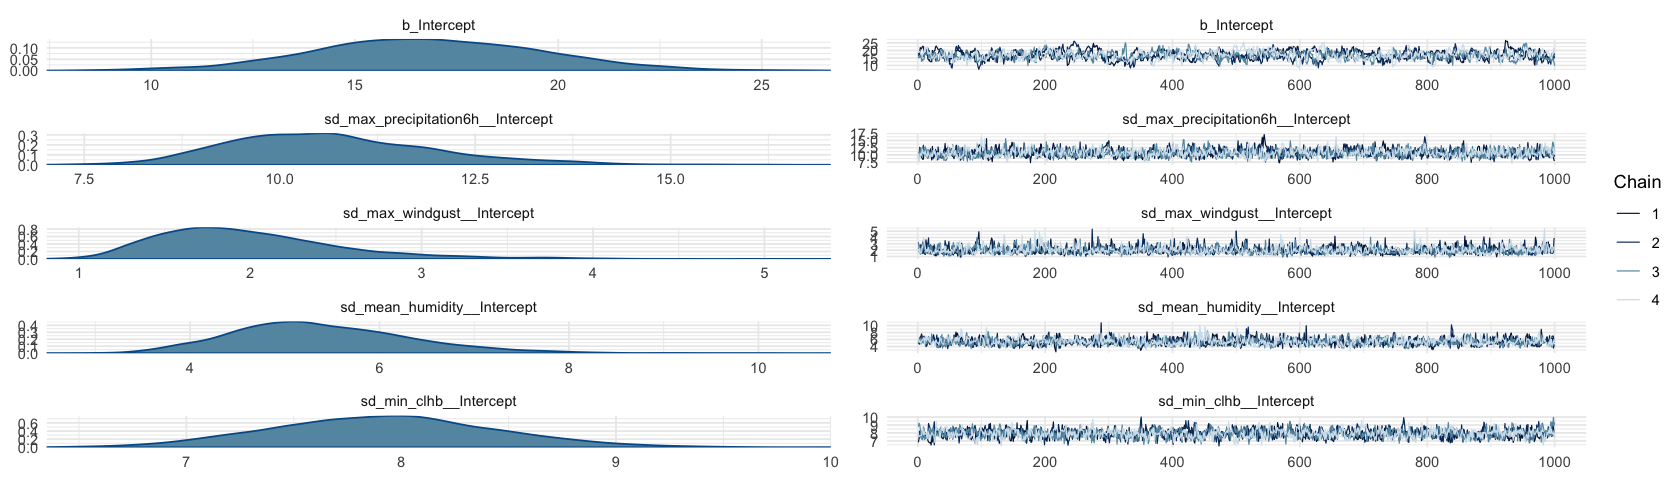

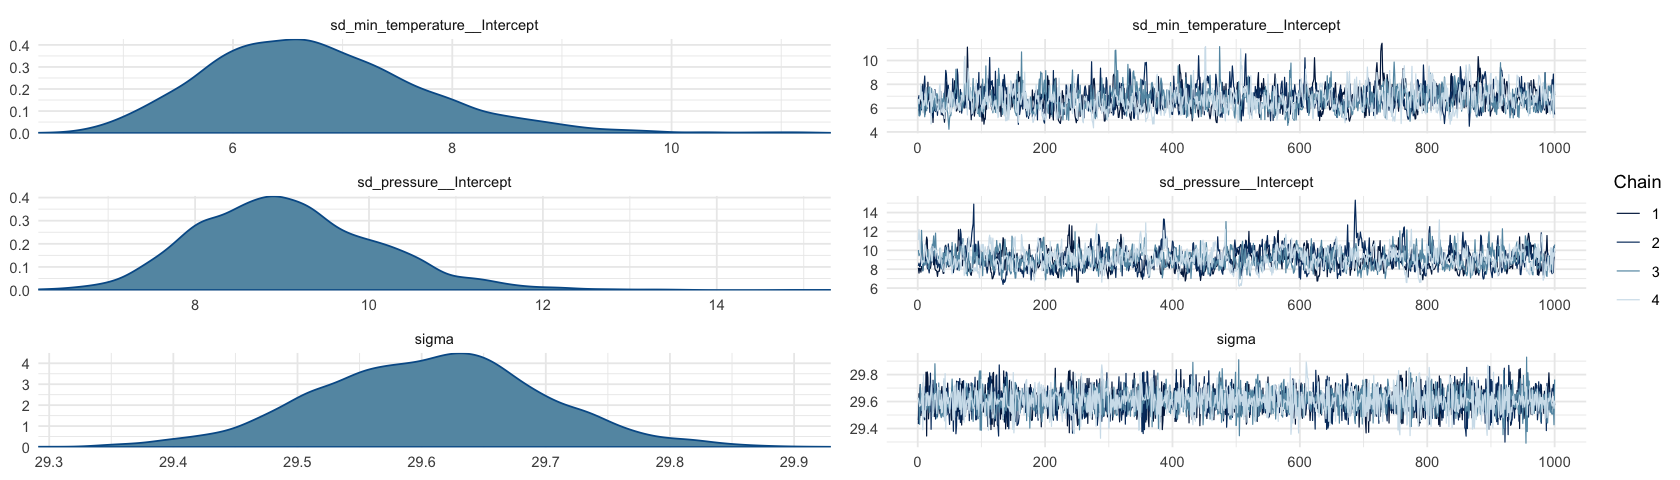

In [127]:
plot(fit1)

# Posterior predictive checking
...

In [128]:
library("bayesplot")
yrep <- posterior_predict(fit1, draws = 500)

Mean value of the simulations (light blue) and the observed data (dark blue).

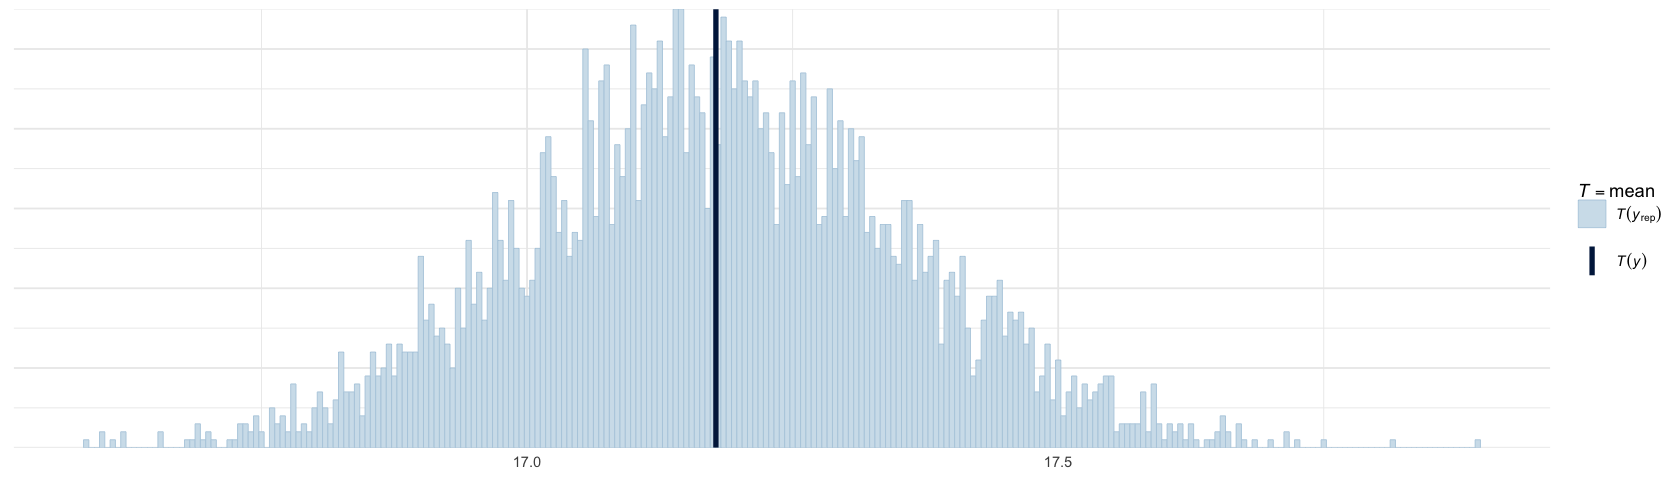

In [129]:
y <- df$delay
ppc_stat(y, yrep, binwidth=.005)

Probability that delay is 0 minutes in the simulations (light blue) and the observed data (dark blue).

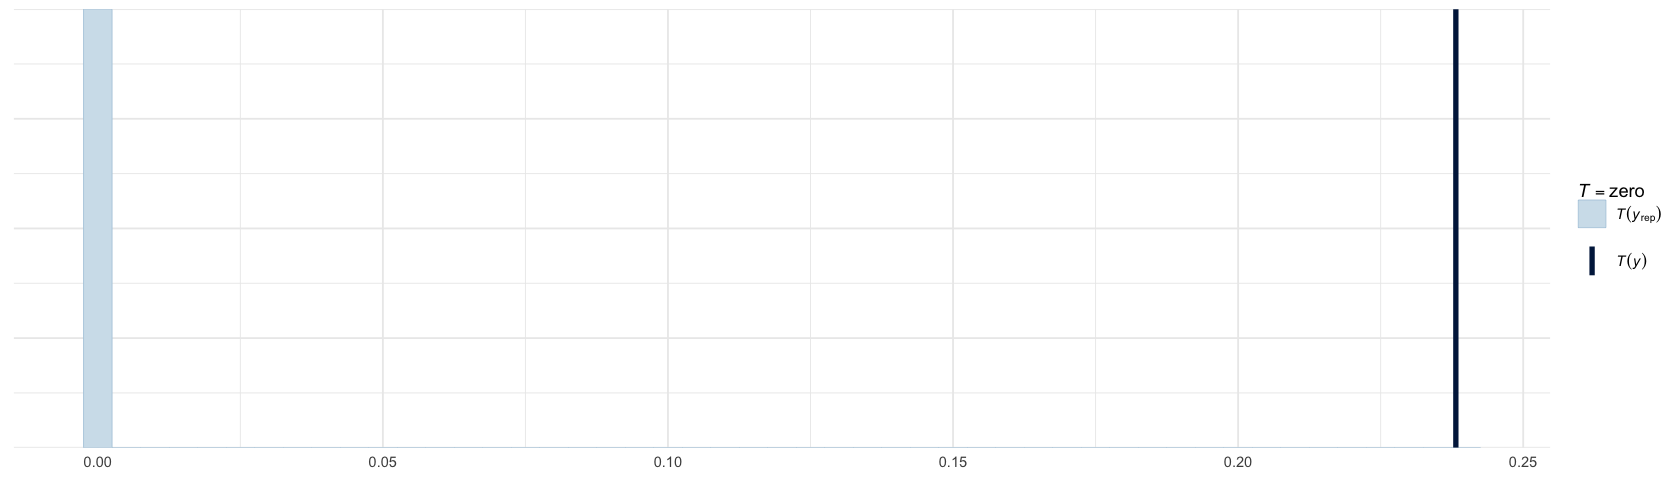

In [130]:
zero <- function(x) mean(x == 0)
ppc_stat(y, yrep, 'zero', binwidth=.005)

Probability that delay is over 5 minutes in the simulations (light blue) and the observed data (dark blue).

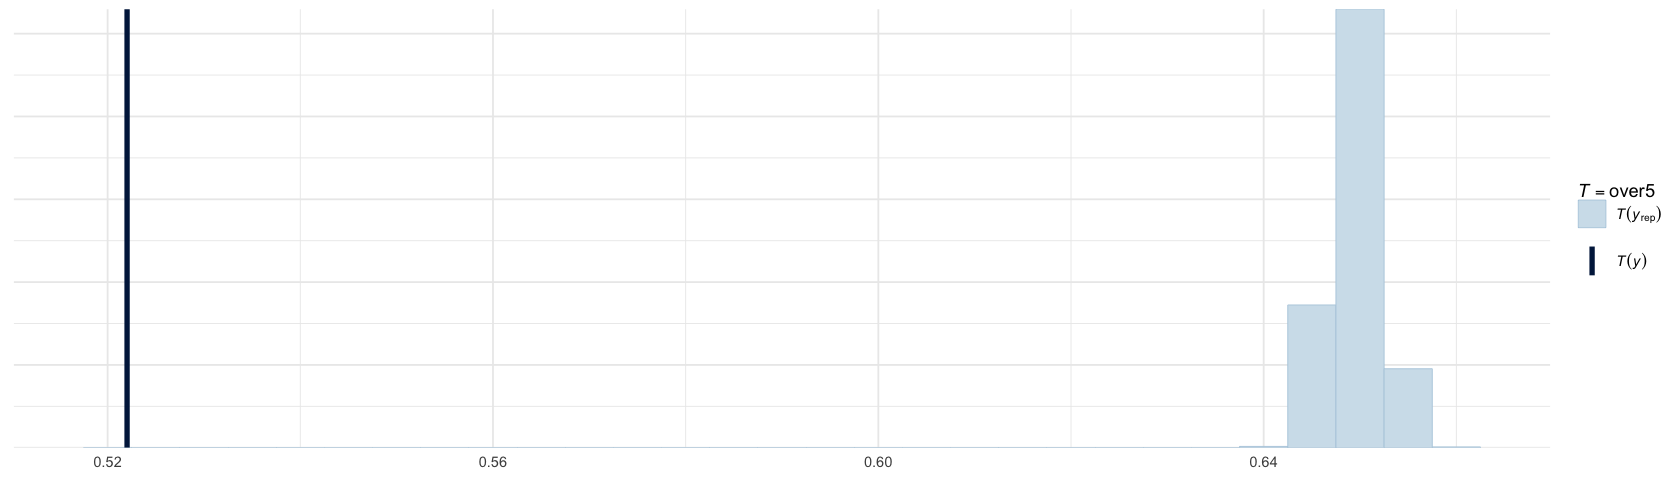

In [131]:
over5 <- function(x) mean(x > 5)
ppc_stat(y, yrep, 'over5', binwidth=.005)

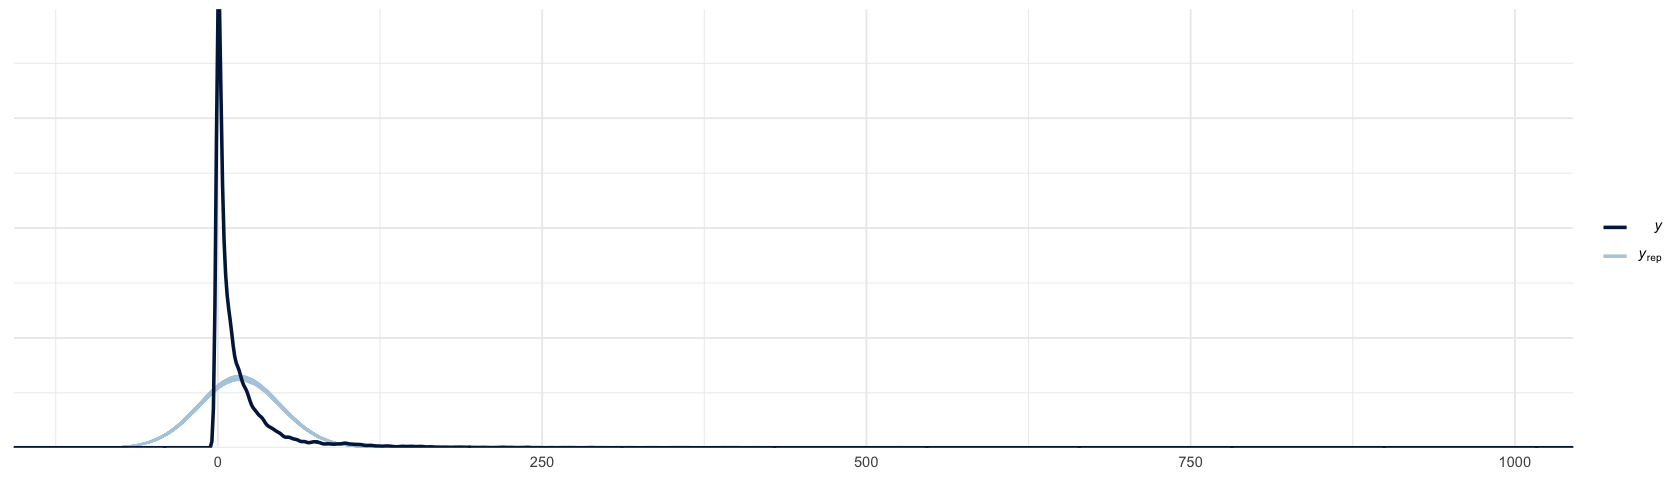

In [132]:
ppc_dens_overlay(y, yrep)

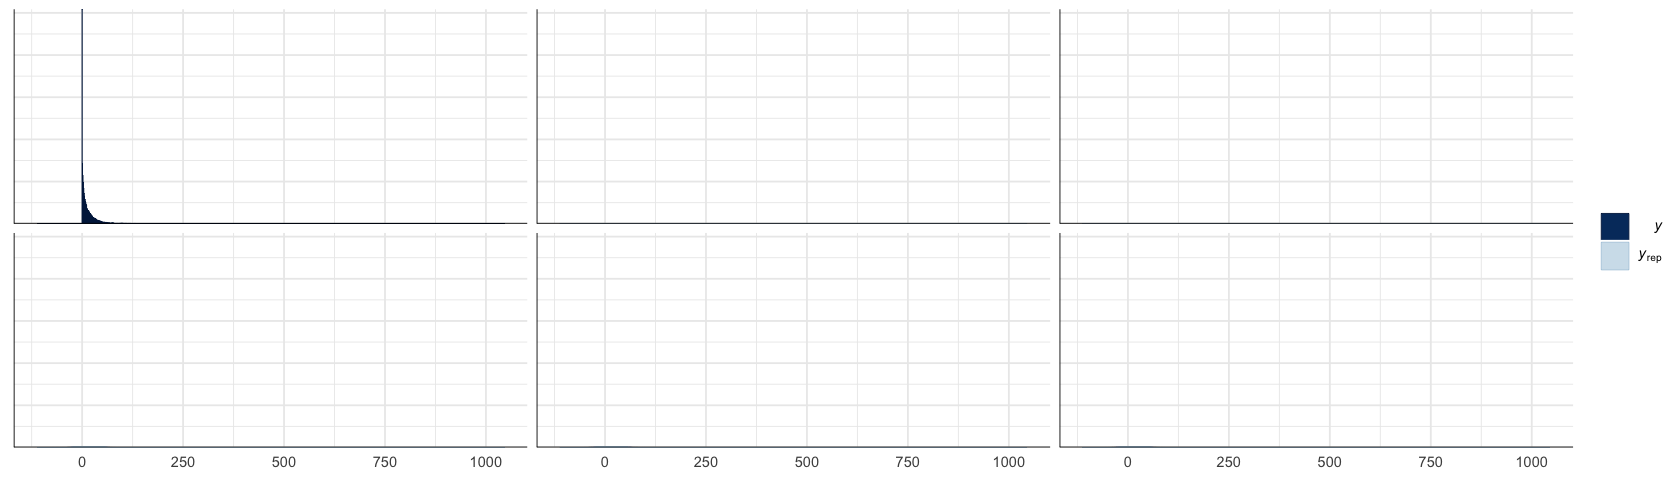

In [133]:
ppc_hist(y, yrep[1:5, ], binwidth=.005)

# Model comparison
...

# Predictive performance assessment
...

In [13]:
validation <- read.csv(val_data_file)
validation$datetime <- anytime::anytime(validation$time)

In [134]:
val_data <- validation[,c('min_temperature', 'pressure')]
pred <- predict(fit1, newdata = val_data, re_formula = NA)
head(pred, 3)

Estimate,Est.Error,Q2.5,Q97.5
16.46614,30.39158,-43.23146,77.62228
16.83367,29.89801,-39.54753,75.87238
16.33982,29.48566,-41.58010,75.22344


    Estimate       Est.Error          Q2.5            Q97.5      
 Min.   :14.71   Min.   :28.44   Min.   :-46.69   Min.   :70.45  
 1st Qu.:16.48   1st Qu.:29.52   1st Qu.:-42.25   1st Qu.:74.16  
 Median :16.80   Median :29.74   Median :-41.41   Median :75.00  
 Mean   :16.80   Mean   :29.74   Mean   :-41.43   Mean   :75.01  
 3rd Qu.:17.11   3rd Qu.:29.96   3rd Qu.:-40.58   3rd Qu.:75.85  
 Max.   :18.92   Max.   :31.16   Max.   :-35.94   Max.   :80.85  

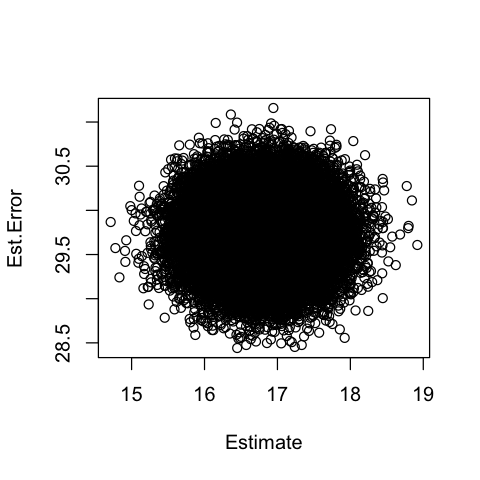

In [135]:
options(repr.plot.width=4, repr.plot.height=4)
summary(pred)
plot(pred)

time,delay,estimate,lower,upper
2011-01-05 07:00:00,1,16.46614,-43.23146,77.62228
2011-01-04 13:00:00,0,16.83367,-39.54753,75.87238
2011-01-05 22:00:00,19,16.33982,-41.58010,75.22344


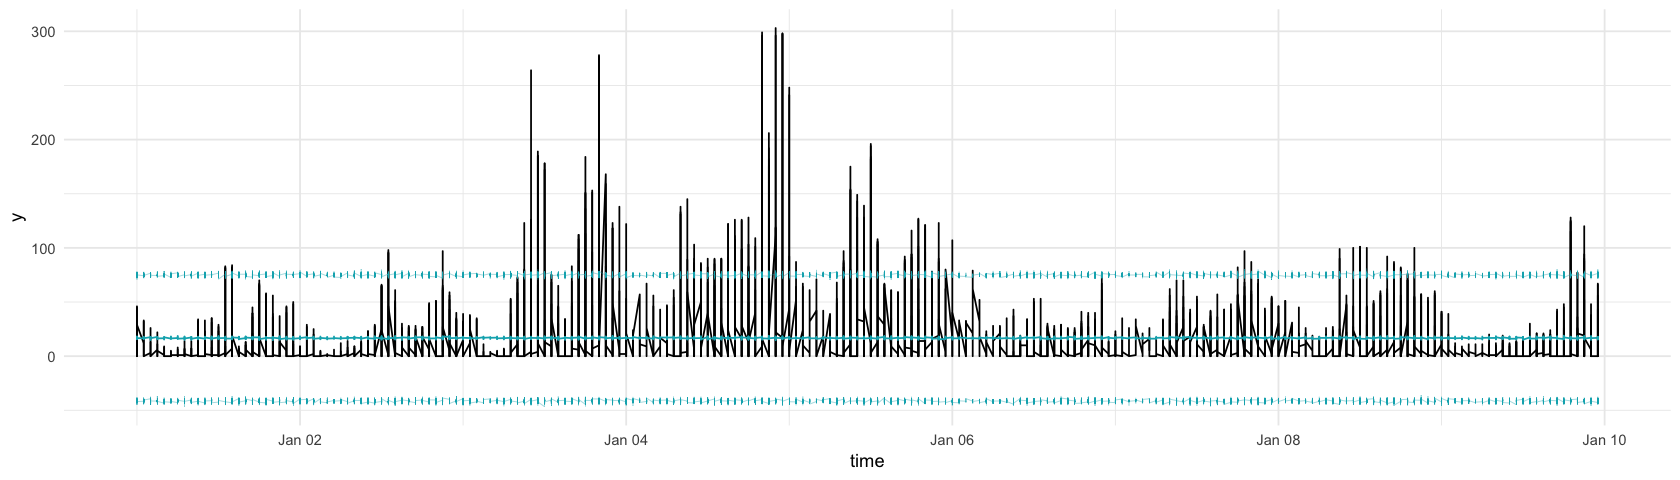

In [136]:
options(repr.plot.width=14, repr.plot.height=4)
val_times <- validation[,c('datetime','delay')]
fitval <- data.frame(cbind(val_times,pred[,-2]))
names(fitval) <- c("time", "delay", "estimate", "lower", "upper")
head(fitval, 3)
ggplot(data=fitval, aes(x = time, y = 'delay')) +
    geom_line(data = fitval, aes(y = delay), size = 0.5) +
    geom_line(data = fitval, aes(y = lower), size = 0.11, col='#00AFBB') +
    geom_line(data = fitval, aes(y = upper), size = 0.11, col='#00AFBB') +
    geom_line(data = fitval, aes(y = estimate), size = 0.5, col='#00AFBB')


In [137]:
rmse <- function(error)
{
    sqrt(mean(error^2))
} 
mae <- function(error)
{
    mean(abs(error))
}
error <- validation[,'delay'] - fitval[,'estimate']
cat(sprintf("RMSE: %.2f\n", rmse(error)))
cat(sprintf("MAE:  %.2f", mae(error)))

RMSE: 19.51
MAE:  14.57

# Sensitivity analysis
...

# Discussion of problems, and potential improvements
...